# Sliding Box LSTMs for churn prediction

This notebook explores the concepts of event forecasting events or churn. This is accomplished by training a reccurent LSTM network which uses slices of time series as features and the occurence of events within these windows as labels. These sliding slices are called sliding boxes.

The notebook is structured as follows:
- exploring the problem
- generating artificial data
- defining the basic model
- training the sliding-box-LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import imageio
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

# Introduction

At first, let's setup some data that helps to understand the problem. Lets assume that we have a timeseries consisting of 20 timesteps and 4 binary features. This might look like this:

[[0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0]
 [1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0]
 [0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1]
 [0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0]]


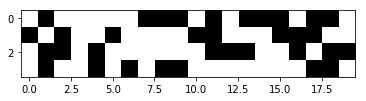

In [2]:
X = np.random.randint(0, 2, size=80).reshape(4,20)
print(X)
plt.imshow(X, cmap="binary")

Out feature vector $y$ is a binary vector that indicates at which timesteps, there is an event of out interest happening. We do not want the event to occur that often so we reduce it's probability like this:

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]


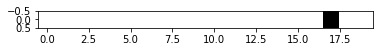

In [3]:
y = np.random.binomial(1, 0.1, size=X.shape[1]).reshape(1,-1)
print(y)
plt.imshow(y, cmap="binary")

## Goal
What we want is to predict the occurence of events (indicated by $y_i=1$) before they happen. The concept is shown below:

In [4]:
from matplotlib import patches as patches

In [5]:
def show_sliding(X, y, tau):
    
    for i in range(X.shape[1]):
        
        print("#"*30)

        X_window = X.T[i:i+tau].T
        y_window = y.T[i:i+tau].T
        indicator = 1 if np.sum(y_window) > 0 else 0
        print("X", X_window, "y", y_window, "I", indicator)

        boxcolor = "r" if indicator else "b"

        fig, axes = plt.subplots(2, sharex=True)
        axes[0].imshow(X, cmap="Greys")
        window = patches.Rectangle((-.55 + i, -.55), tau, X.shape[0], alpha=0.4, color=boxcolor)
        axes[0].add_patch(window)

        axes[1].imshow(y, cmap="binary")
        window = patches.Rectangle((-.55 + i, -.55), tau, X.shape[0], alpha=0.4, color=boxcolor)
        axes[1].add_patch(window)

        plt.show()

##############################
X [[0 1 0]
 [1 0 1]
 [0 1 1]
 [0 1 0]] y [[0 0 0]] I 0


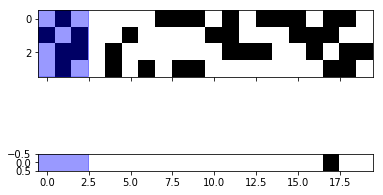

##############################
X [[1 0 0]
 [0 1 0]
 [1 1 0]
 [1 0 0]] y [[0 0 0]] I 0


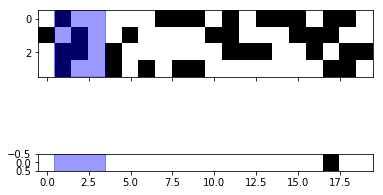

##############################
X [[0 0 0]
 [1 0 0]
 [1 0 1]
 [0 0 1]] y [[0 0 0]] I 0


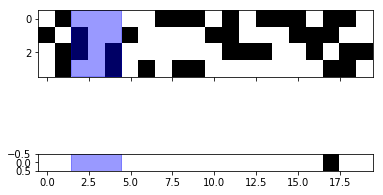

##############################
X [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]] y [[0 0 0]] I 0


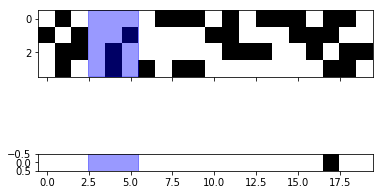

##############################
X [[0 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 1]] y [[0 0 0]] I 0


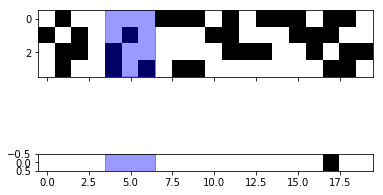

##############################
X [[0 0 1]
 [1 0 0]
 [0 0 0]
 [0 1 0]] y [[0 0 0]] I 0


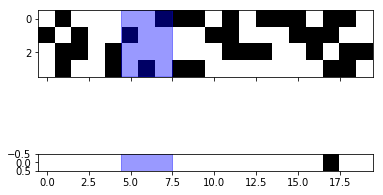

##############################
X [[0 1 1]
 [0 0 0]
 [0 0 0]
 [1 0 1]] y [[0 0 0]] I 0


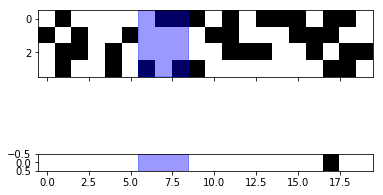

##############################
X [[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 1 1]] y [[0 0 0]] I 0


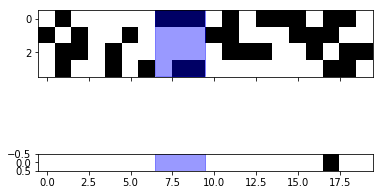

##############################
X [[1 1 0]
 [0 0 1]
 [0 0 0]
 [1 1 0]] y [[0 0 0]] I 0


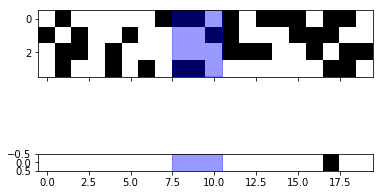

##############################
X [[1 0 1]
 [0 1 1]
 [0 0 1]
 [1 0 0]] y [[0 0 0]] I 0


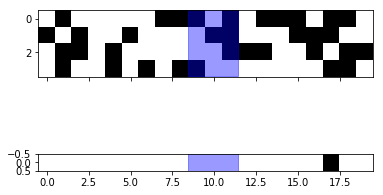

##############################
X [[0 1 0]
 [1 1 0]
 [0 1 1]
 [0 0 0]] y [[0 0 0]] I 0


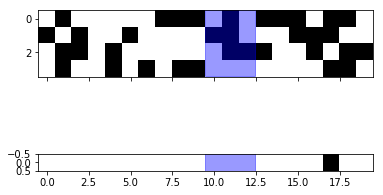

##############################
X [[1 0 1]
 [1 0 0]
 [1 1 1]
 [0 0 0]] y [[0 0 0]] I 0


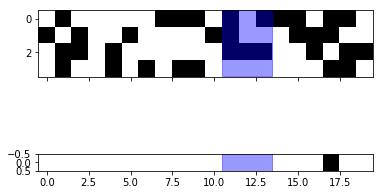

##############################
X [[0 1 1]
 [0 0 0]
 [1 1 0]
 [0 0 0]] y [[0 0 0]] I 0


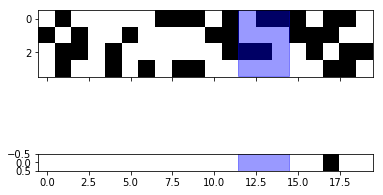

##############################
X [[1 1 1]
 [0 0 1]
 [1 0 0]
 [0 0 0]] y [[0 0 0]] I 0


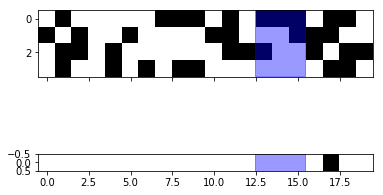

##############################
X [[1 1 0]
 [0 1 1]
 [0 0 1]
 [0 0 0]] y [[0 0 0]] I 0


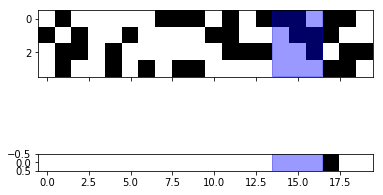

##############################
X [[1 0 1]
 [1 1 1]
 [0 1 0]
 [0 0 1]] y [[0 0 1]] I 1


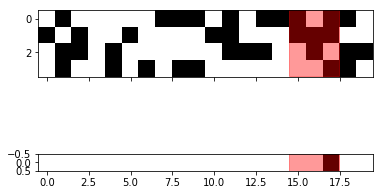

##############################
X [[0 1 1]
 [1 1 0]
 [1 0 1]
 [0 1 1]] y [[0 1 0]] I 1


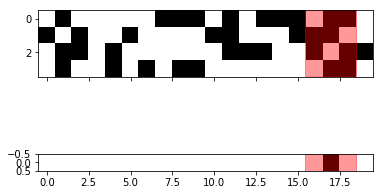

##############################
X [[1 1 0]
 [1 0 0]
 [0 1 1]
 [1 1 0]] y [[1 0 0]] I 1


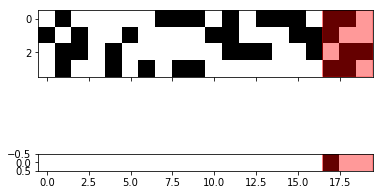

##############################
X [[1 0]
 [0 0]
 [1 1]
 [1 0]] y [[0 0]] I 0


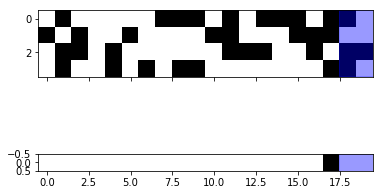

##############################
X [[0]
 [0]
 [1]
 [0]] y [[0]] I 0


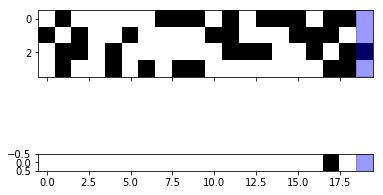

In [6]:
tau = 3     # window size
show_sliding(X, y, tau)

So our training examples at timestep $t$ comprise the slice of features from $X$ with $\tau$ timesteps ahead resulting in the slice $X_{t:t+\tau}$. The corresponding label $y^{(i)}$ for each timewindow $X_{t:t+\tau}^{(i)}$ is indicated by the occurence of an event of interest during the current time window (box becomes red).

When using this concept of binary classification, we can state so far that:
- We are able to train on sequences with arbitrary lengths
- Our time window is fixed parameter which must be chose carefully

In [7]:
# TODO: discuss choosing tau

Let's look at a model that can be used for predicting y.

# Sliding Box Model

In [8]:
# todo: describe

$$ B_t \sim Bernoulli(\theta_T) $$

$$ 
    b_t=
    \left\{
    \begin{array}{lr}
    1,& \text{If event happened in } [t, t + \tau)\\
    0,& Else
    \end{array}
    \right\}
    $$

$$ Pr(B_t=b_t)=\theta_t^{b_t} \cdot (1-\theta_t)^{1-b_t} $$

$\theta_t$ is a function of data available at time $\theta_t = g(x_{0:t})$. So we estimate the probability of an event happening in our sliding box model of width $\tau$.

$$\underset{\theta_t}{\text{maximize}}  \mathfrak{L}(\theta_t) := \theta_t^{b_t} \cdot (1-\theta_t)^{1-b_t}$$

## Build toy data

Let's build a synthetic dataset where we can run tests agains. 

In [9]:
# Makes binary features more likely towards the end of the series
def linear_increase_binomial_prob(x, scale=1):
    return np.random.binomial(1, x/(len(x)*scale), len(x))

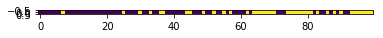

In [10]:
plt.imshow(linear_increase_binomial_prob(np.arange(100), scale=1.5).reshape(1,-1))

In [11]:
# Generate an artificial target vector
def make_y(m, p=0.08):
    return np.random.binomial(1,p,m).reshape(1,-1)

In [12]:
# Generate artificial feature vector of time series
def make_X(m, scales):
    x = np.arange(m)
    X = []
    for scale in scales:
        X.append(linear_increase_binomial_prob(x, scale))
        
    return np.array(X)

In [13]:
# Make the data

In [14]:
m = 20
scales = [10,15,1,20, 10, 5]        # vary feature distribution
    
X = make_X(m, scales)
y = make_y(m, p=0.08)

print(X.shape)
print(y.shape)

(6, 20)
(1, 20)


In [15]:
from src import helper

In [16]:
filename = "sliding_box"

helper.dump_animation(X, y, 3, filename, fps=2)

<img src="sliding_box.gif"/>

In [17]:
# Disassembles series and it's targets to separate window slices
def convert_series_to_Xy(X, y, window):
    
    Xs = []
    Ys = []
    n = X.shape[0]
    
    for i in range(len(X.T)-window+1):

        X_window = X.T[i:i+window].T
        y_window = y.T[i:i+window].T

        indicator = 1 if np.sum(y_window) > 0 else 0
        
        Xs.append(X_window.T)
        Ys.append(indicator)
        
    return np.array(Xs), np.array(Ys).reshape(1,-1).T


In [18]:
# input shapes are
# Samples (one sequence)
# Time Steps (one point of observation)
# Features
# --> data.shape(samples, timesteps, numfeatures) 

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 1]] I 1


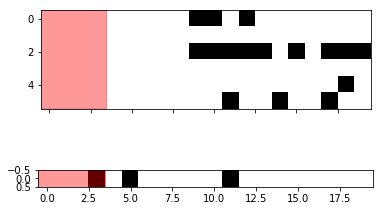

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 1 0]] I 1


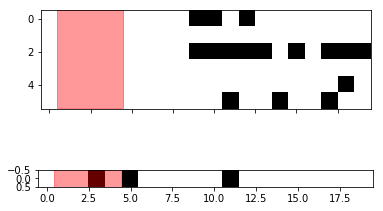

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 1 0 1]] I 1


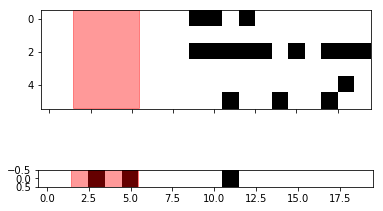

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[1 0 1 0]] I 1


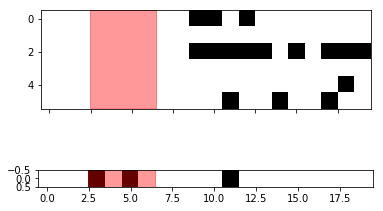

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 1 0 0]] I 1


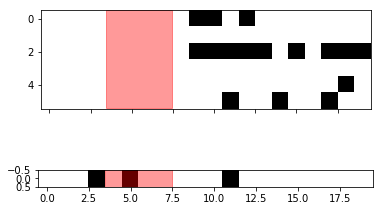

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[1 0 0 0]] I 1


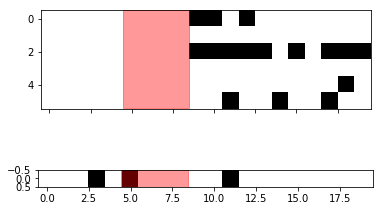

##############################
X [[0 0 0 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


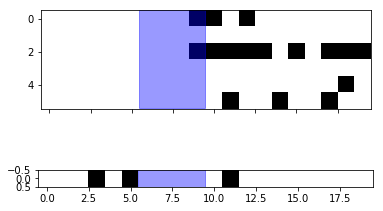

##############################
X [[0 0 1 1]
 [0 0 0 0]
 [0 0 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


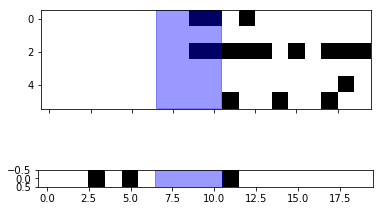

##############################
X [[0 1 1 0]
 [0 0 0 0]
 [0 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]] y [[0 0 0 1]] I 1


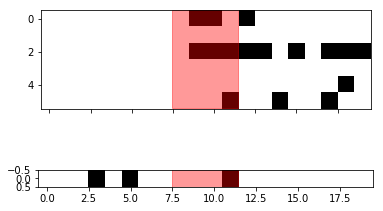

##############################
X [[1 1 0 1]
 [0 0 0 0]
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]] y [[0 0 1 0]] I 1


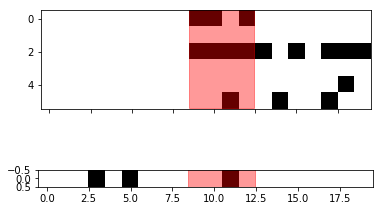

##############################
X [[1 0 1 0]
 [0 0 0 0]
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]] y [[0 1 0 0]] I 1


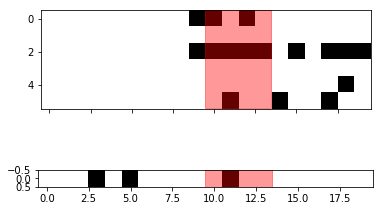

##############################
X [[0 1 0 0]
 [0 0 0 0]
 [1 1 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 1]] y [[1 0 0 0]] I 1


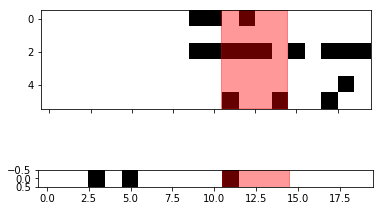

##############################
X [[1 0 0 0]
 [0 0 0 0]
 [1 1 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]] y [[0 0 0 0]] I 0


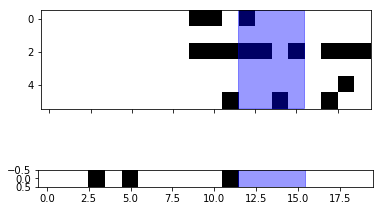

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [1 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]] y [[0 0 0 0]] I 0


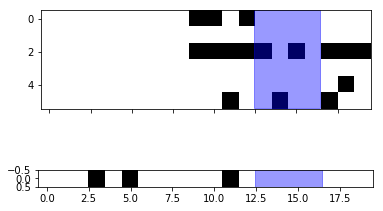

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 1 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 1]] y [[0 0 0 0]] I 0


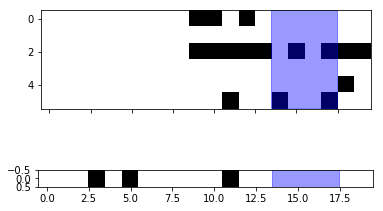

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [1 0 1 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]] y [[0 0 0 0]] I 0


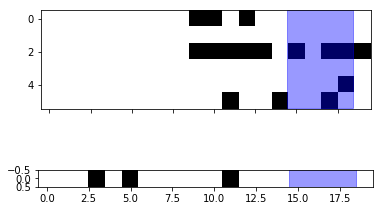

##############################
X [[0 0 0 0]
 [0 0 0 0]
 [0 1 1 1]
 [0 0 0 0]
 [0 0 1 0]
 [0 1 0 0]] y [[0 0 0 0]] I 0


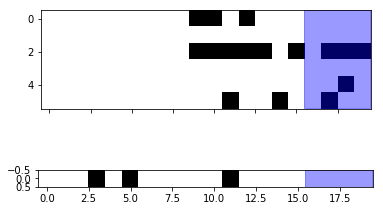

##############################
X [[0 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [0 1 0]
 [1 0 0]] y [[0 0 0]] I 0


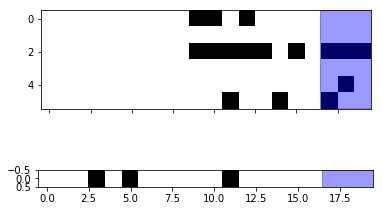

##############################
X [[0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [0 0]] y [[0 0]] I 0


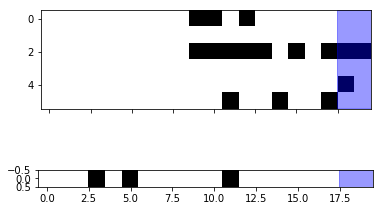

##############################
X [[0]
 [0]
 [1]
 [0]
 [0]
 [0]] y [[0]] I 0


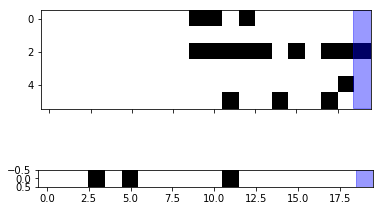

In [19]:
show_sliding(X, y, 4)

In [20]:
print(X.shape)
print(y.shape)

(6, 20)
(1, 20)


In [21]:
tau = 4
n   = X.shape[0]

Xs, Ys = convert_series_to_Xy(X, y, tau)
print(Xs.shape)
print(Ys.shape)

(17, 4, 6)
(17, 1)


In [22]:
def make_model(tau, n):
    
    model = Sequential()
    model.add(LSTM(32, input_shape=(tau, n)))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])    # Bernoulli Log-Likelihood
    
    return model

In [23]:
model = make_model(tau, n)

In [24]:
result = model.fit(Xs, Ys, epochs=20, batch_size=32)

Epoch 1/20
17/17 [==============================] - 1s 31ms/sample - loss: 0.7005 - accuracy: 0.2353
Epoch 2/20
17/17 [==============================] - 0s 265us/sample - loss: 0.6992 - accuracy: 0.5882
Epoch 3/20
17/17 [==============================] - 0s 265us/sample - loss: 0.6980 - accuracy: 0.5882
Epoch 4/20
17/17 [==============================] - 0s 265us/sample - loss: 0.6968 - accuracy: 0.5882
Epoch 5/20
17/17 [==============================] - 0s 295us/sample - loss: 0.6955 - accuracy: 0.5882
Epoch 6/20
17/17 [==============================] - 0s 235us/sample - loss: 0.6943 - accuracy: 0.5882
Epoch 7/20
17/17 [==============================] - 0s 235us/sample - loss: 0.6931 - accuracy: 0.5882
Epoch 8/20
17/17 [==============================] - 0s 325us/sample - loss: 0.6919 - accuracy: 0.5882
Epoch 9/20
17/17 [==============================] - 0s 236us/sample - loss: 0.6907 - accuracy: 0.5882
Epoch 10/20
17/17 [==============================] - 0s 294us/sample - loss: 0.6895

In [25]:
predictions = model.predict(Xs)

## Show Predictions

In [26]:
for i, j, pred in zip(Xs, Ys, predictions):
    
    print(i, j, pred)
#     plt.imshow(i.T, cmap="binary")
    plt.show()

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [1] [0.52800405]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [1] [0.52800405]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [1] [0.52800405]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [1] [0.52800405]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [1] [0.52800405]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [1] [0.52800405]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 0 0]] [0] [0.5334561]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 0 0]
 [1 0 1 0 0 0]] [0] [0.5406684]
[[0 0 0 0 0 0]
 [1 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 1 0 0 1]] [1] [0.544345]
[[1 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 1 0 0 1]
 [1 0 1 0 0 0]] [1] [0.53855133]
[[1 0 1 0 0 0]
 [0 0 1 0 0 1]
 [1 0 1 0 0 0]
 [0 0 1 0 0 0]] [1] [0.53663534]
[[0 0 1 0 0 1]
 [1 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]] [1] [0.51795393]
[[1 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]] [0] [0.

# Make more realistic data

In [27]:
m = 5                                     # number of time series to be generated
ts_pool = [7,7,8,8,9,10,10,10,14,15,13]    #  simulate different lengths of time series
n = 4                                      # number of features
class_balance = 0.4                        # probability of label y==1

ts_X, ts_Y = [], []

for i in range(m):
    
    ts_len = np.random.choice(ts_pool)
    
    hasevent = np.random.binomial(1, class_balance, 1)
    
    if hasevent:
        X = make_X(ts_len, [1,1,1.2,1.5])     # make appearance of features more likely
        y = np.zeros((1,ts_len))
        y[0,-1] = 1                           # put a one at the end
        
    else:
        X = make_X(ts_len, [10,8,5,9])        # make appearance features less likely
        y = np.zeros((1,ts_len))              # all labels are zero (no event)
        
    ts_X.append(X)
    ts_Y.append(y)


In [28]:
tau = 3    # time window

model = make_model(tau, n)

for ts_x, ts_y in zip(ts_X, ts_Y):
        
    ts_x_windows, ts_y_windows = convert_series_to_Xy(ts_x, ts_y, tau)

    model.fit(ts_x_windows, ts_y_windows)
    

8/8 [==============================] - 0s 437us/sample - loss: 0.6774 - accuracy: 1.0000


In [29]:
def stack_ts(ts_X, ts_Y, tau):
    
    K, L = [],[]

    for i, j in zip(ts_X, ts_Y):

        k, l = convert_series_to_Xy(i, j, tau)

        K.append(k)
        L.append(l)


    ts_X_stacked = np.vstack([i for i in K])
    ts_Y_stacked = np.vstack([i for i in L])
    
    return ts_X_stacked, ts_Y_stacked

In [30]:
ts_X_stacked, ts_Y_stacked = stack_ts(ts_X, ts_Y, tau)

In [31]:
print(ts_X_stacked.shape)
print(ts_Y_stacked.shape)

(48, 3, 4)
(48, 1)


In [32]:
model = make_model(tau, ts_X_stacked.shape[2])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_2 (UnifiedLSTM) (None, 32)                4736      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
